In [260]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to display images
def show_image(title, img, cmap_type="gray"):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.imshow(img, cmap=cmap_type)
    plt.axis("off")
    plt.show()

def area(contour):
    # Get the bounding box of the contour (top-left corner, width, height)
    _, _, w, h = cv2.boundingRect(contour)
    
    # Calculate the area of the bounding rectangle
    bounding_rect_area = w * h
    return bounding_rect_area

# Load the image
image_path = 'data/table_topdown_006.png'  # Update this with your image path
original_img = cv2.imread(image_path)
# resize the image to width = 1200, height = auto
original_img = cv2.resize(original_img, (1500, int(1500/original_img.shape[1]*original_img.shape[0])))

gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 1)

# Step 0: Compute dynamic thresholds
median_intensity = np.median(blurred_img)
lower_threshold = int(max(0, 0.1 * median_intensity))
upper_threshold = int(min(255, 1.1 * median_intensity))
print(f"Dynamic Thresholds: {lower_threshold}, {upper_threshold}")

# Step 1: Detect the table (using edge detection and contour finding)
edges = cv2.Canny(blurred_img, lower_threshold, upper_threshold)
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

print("Number of contours:", len(contours))


Dynamic Thresholds: 14, 155
Number of contours: 124


Number of filtered contours: 7
0 -- Contour Area: 794840, color: [42, 141, 21], distance: 1.0, approx: 4, ratio: 1.9344773790951637
1 -- Contour Area: 794840, color: [1, 126, 170], distance: 2.8284271247461903, approx: 4, ratio: 1.9344773790951637
2 -- Contour Area: 810601, color: [142, 181, 151], distance: 12.0, approx: 4, ratio: 1.9244992295839753
3 -- Contour Area: 810601, color: [189, 215, 19], distance: 1.4142135623730951, approx: 4, ratio: 1.9244992295839753
4 -- Contour Area: 900025, color: [247, 20, 199], distance: 80.0, approx: 4, ratio: 1.8633093525179856
5 -- Contour Area: 900025, color: [63, 120, 31], distance: 21.0, approx: 4, ratio: 1.8633093525179856
6 -- Contour Area: 1142898, color: [82, 17, 199], distance: 161.0, approx: 10, ratio: 1.7992471769134253
Table Area: 770799.5
Rectangle vertices: [(np.int32(130), np.int32(139)), (np.int32(1366), np.int32(149)), (np.int32(1356), np.int32(774)), (np.int32(132), np.int32(765))]


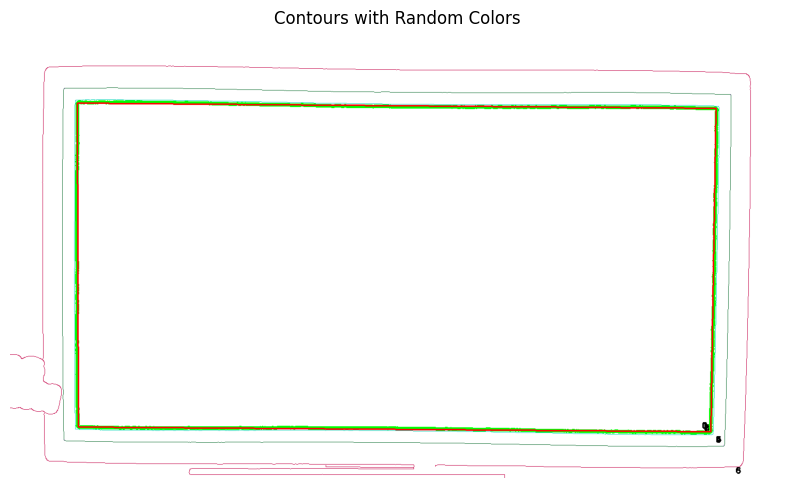

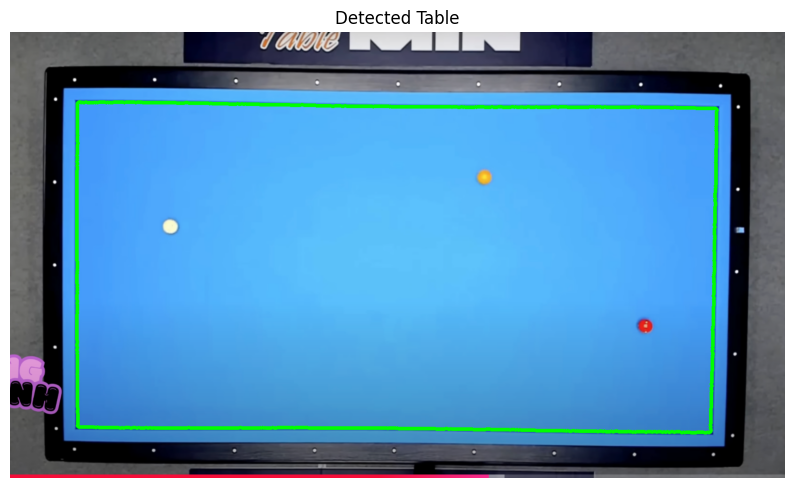

In [261]:
def contour_rect_ratio(contour):
    _, _, w, h = cv2.boundingRect(contour)
    return float(w) / h

def is_table(contour, image_shape):
    ratio = contour_rect_ratio(contour)
    _, _, w, h = cv2.boundingRect(contour)
    approx = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour, True), True)
    return ratio < 2 and ratio > 1.5 and w > image_shape[1] * 0.5 and h > image_shape[0] * 0.5 # and len(approx) == 4

filtered_contours = [contour for contour in contours if is_table(contour, original_img.shape)]
print("Number of filtered contours:", len(filtered_contours))

canvas = np.ones_like(original_img) * 255  # White canvas (255 represents white in BGR)
# Draw each contour with a random color
for idx, contour in enumerate(filtered_contours):
    # Generate a random color (BGR format)
    color = [random.randint(0, 255) for _ in range(3)]
    distance = np.linalg.norm(contour[0][0] - contour[-1][0])
    approx = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour, True), True)
    ratio = contour_rect_ratio(contour)

    # Print the area of the contour
    print(f"{idx} -- Contour Area: {area(contour)}, color: {color}, distance: {distance}, approx: {len(approx)}, ratio: {ratio}")
    
    # Draw the contour on the canvas
    cv2.drawContours(canvas, [contour], -1, color, thickness=1)
    
    x, y, w, h = cv2.boundingRect(contour)
    # Draw the index of the contour at the top-left point of the bounding box
    cv2.putText(canvas, str(idx), (x+w-30, y+h-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)


# Create a white canvas (same size as the input image)
# table countour is the one with 2nd smallest area

table_contour = min(filtered_contours, key=area)
cv2.drawContours(canvas, [table_contour], -1, (0, 255, 0), thickness=5)
print(f"Table Area: {cv2.contourArea(table_contour)}")

# Approximate the contour
epsilon = 0.02 * cv2.arcLength(contour, True)  # 2% of arc length
approx = cv2.approxPolyDP(table_contour, epsilon, True)

# Check if the approximated contour has 4 vertices
if len(approx) == 4:
    # Check if the contour is convex
    if cv2.isContourConvex(approx):
        # Extract the 4 vertices
        vertices = [tuple(point[0]) for point in approx]
        print(f"Rectangle vertices: {vertices}")

        # Draw the rectangle on the canvas
        cv2.polylines(canvas, [approx], isClosed=True, color=(0, 0, 255), thickness=2)

# Convert the canvas to RGB for displaying using matplotlib
canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

white_canvas = np.ones_like(edges) * 255  # White background of the same size as edges

# Highlight edges by coloring them black (or another color)
# highlighted_edges = cv2.bitwise_not(white_canvas)  # Start with a black canvas
white_canvas[edges > 0] = 0  # Mark edges as black on the white canvas

# Optional: Convert to RGB if you want to display with Matplotlib
highlighted_edges_rgb = cv2.cvtColor(white_canvas, cv2.COLOR_GRAY2RGB)

# # Display the result
# plt.figure(figsize=(10, 10))
# plt.imshow(highlighted_edges_rgb)
# plt.title("Highlighted Edges on White Background")
# plt.axis("off")
# plt.show()

# plt.figure(figsize=(10, 10))
# plt.imshow(edges, cmap='gray')  # Use 'gray' colormap for edge visualization
# plt.title("Detected Edges")
# plt.axis("off")  # Hide axis for better visualization
# plt.show()

# Display the image with contours
plt.figure(figsize=(10, 6))
plt.imshow(canvas_rgb)
plt.title("Contours with Random Colors")
plt.axis('off')

# line_canvas = np.ones_like(original_img) * 255  # White canvas (255 represents white in BGR)
# for idx, contour in enumerate(filtered_contours):
#     if (idx != 0):
#         continue
#     # Approximate the contour
#     epsilon = 0.02 * cv2.arcLength(contour, True)
#     approx = cv2.approxPolyDP(contour, epsilon, True)

#     # Draw lines between consecutive points
#     for i in range(len(approx)):
#         pt1 = tuple(approx[i][0])  # Current point
#         pt2 = tuple(approx[(i + 1) % len(approx)][0])  # Next point (cyclic)
        
#         # Draw the line on the canvas
#         cv2.line(canvas, pt1, pt2, (0, 0, 255), 2)

# # Display the result
# plt.figure(figsize=(10, 5))
# plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
# plt.title("Detected Lines from Contours")
# plt.axis("off")

# clone original image
table_detected = original_img.copy()
# Draw the table contour on the image
cv2.drawContours(table_detected, [table_contour], -1, (0, 255, 0), thickness=5)

# Display the result
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(table_detected, cv2.COLOR_BGR2RGB))
plt.title("Detected Table")
plt.axis("off")

plt.show()

Number of White balls detected: 79
Number of Yellow balls detected: 1
Number of Red balls detected: 1


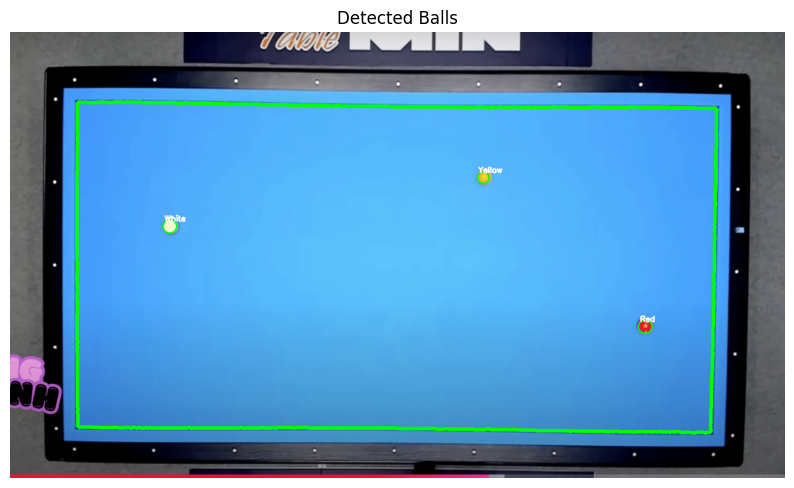

In [262]:
hsv = cv2.cvtColor(original_img, cv2.COLOR_BGR2HSV)

# Define HSV ranges for the colors
# Adjust these ranges as needed for your image
# White ball
lower_white = np.array([0, 0, 200])  # Low saturation, high brightness
upper_white = np.array([180, 55, 255])

# Yellow ball
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([30, 255, 255])

# Red ball
lower_red1 = np.array([0, 120, 70])  # Red has two ranges in HSV
upper_red1 = np.array([10, 255, 255])
lower_red2 = np.array([170, 120, 70])
upper_red2 = np.array([180, 255, 255])

# Blue table (to mask out the table)
lower_blue = np.array([100, 150, 50])
upper_blue = np.array([140, 255, 255])

# Create masks for each ball
mask_white = cv2.inRange(hsv, lower_white, upper_white)
mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
mask_red = cv2.bitwise_or(mask_red1, mask_red2)  # Combine the two red ranges
mask_table = cv2.inRange(hsv, lower_blue, upper_blue)

# Remove table from the ball masks
mask_white = cv2.subtract(mask_white, mask_table)
mask_yellow = cv2.subtract(mask_yellow, mask_table)
mask_red = cv2.subtract(mask_red, mask_table)

# Clean up masks with morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_white = cv2.morphologyEx(mask_white, cv2.MORPH_CLOSE, kernel)
mask_yellow = cv2.morphologyEx(mask_yellow, cv2.MORPH_CLOSE, kernel)
mask_red = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, kernel)

# Display the masks
# show_image("White Mask", mask_white)
# show_image("Yellow Mask", mask_yellow)
# show_image("Red Mask", mask_red)

table_rect = cv2.boundingRect(table_contour)

# Detect circles for each mask using Hough Circle Transform
def detect_circles(mask, color_name, output_img):
    circles = cv2.HoughCircles(
        mask,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=10,
        param1=5,
        param2=10,
        minRadius=5,
        maxRadius=50,
    )
    print(f"Number of {color_name} balls detected:", 0 if circles is None else len(circles[0]))
    balls = []
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            if table_rect[0] <= x <= table_rect[0] + table_rect[2] and table_rect[1] <= y <= table_rect[1] + table_rect[3]:
                balls.append((x, y, r))
                # Draw detected circles on the original image
                cv2.circle(output_img, (x, y), r, (0, 255, 0), 2)
                cv2.putText(
                    output_img, color_name, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2
                )
    return balls

# Detect and annotate each ball
white_ball = detect_circles(mask_white, "White", table_detected)[0]
yellow_ball = detect_circles(mask_yellow, "Yellow", table_detected)[0]
red_ball = detect_circles(mask_red, "Red", table_detected)[0]

# Display the final result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(table_detected, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detected Balls")
plt.show()

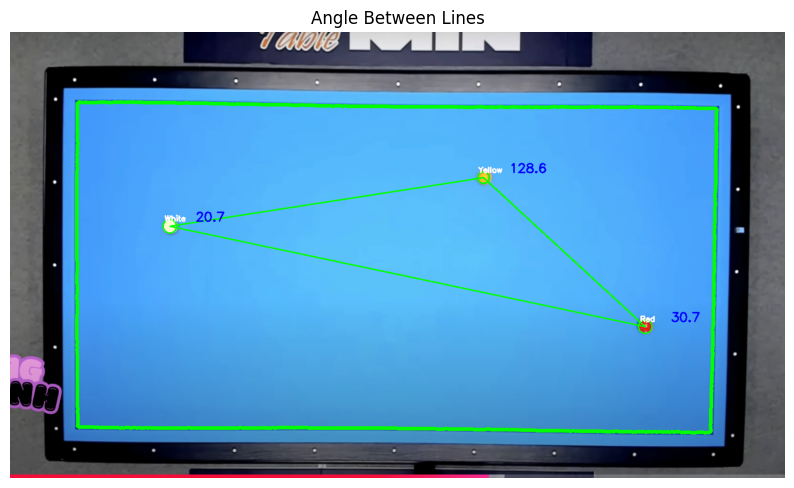

In [263]:
white_center = (white_ball[0], white_ball[1])
yellow_center = (yellow_ball[0], yellow_ball[1])
red_center = (red_ball[0], red_ball[1])

# Draw lines between the centers
cv2.line(table_detected, white_center, yellow_center, (0, 255, 0), 2)
cv2.line(table_detected, yellow_center, red_center, (0, 255, 0), 2)
cv2.line(table_detected, red_center, white_center, (0, 255, 0), 2)

def detect_angle(end_point1, end_point2, vertex):
    # Calculate vectors
    v1 = np.array(vertex) - np.array(end_point1)
    v2 = np.array(end_point2) - np.array(vertex)

    # Calculate the angle in radians and convert to degrees
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip for numerical stability
    angle_deg = 180 - np.degrees(angle)

    # Annotate the angle near the yellow ball center
    angle_position = (vertex[0] + 50, vertex[1] - 10)  # Adjust position as needed
    cv2.putText(
        table_detected,
        f"{angle_deg:.1f}",
        angle_position,
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (255, 0, 0),
        2,
    )

    return angle_deg

detect_angle(white_center, yellow_center, red_center)
detect_angle(yellow_center, red_center, white_center)
detect_angle(red_center, white_center, yellow_center)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(table_detected, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Angle Between Lines")
plt.show()